<a href="https://colab.research.google.com/github/Danish-Hussain-DSAI/final-year-project-deepfake-image-detection-researched-based/blob/main/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#  !7za -y x "/content/drive/MyDrive/images.zip"


#-------------- **STEP 1 :LOAD  IMAGES FROM DIRECTORY**------------

----------Load **Fake Images** from local directory--------

In [4]:
import tensorflow as tf

# Replace 'your_directory_path' with the path to your dataset directory
Fake_images_path = '/content/images/fake'

# Define parameters for the dataset
batch_size = 32
image_size = (128, 128)  # Adjust the size as needed

# Create the image dataset from the directory
fake_images_dataset = tf.keras.utils.image_dataset_from_directory(
    Fake_images_path,
    batch_size=batch_size,
    image_size=image_size,
    label_mode=None,  # Set to None if you only want images without labels
    shuffle=True,     # Set to True if you want to shuffle the dataset
)



Found 20004 files belonging to 1 classes.


---------------Load **Real Images** From directory------------

In [5]:
import tensorflow as tf

# Replace 'your_directory_path' with the path to your dataset directory
real_images_path = '/content/images/real'

# Define parameters for the dataset
batch_size = 32
image_size = (128, 128)  # Adjust the size as needed

# Create the image dataset from the directory
real_images_dataset = tf.keras.utils.image_dataset_from_directory(
    real_images_path,
    batch_size=batch_size,
    image_size=image_size,
    label_mode=None,  # Set to None if you only want images without labels
    shuffle=True,     # Set to True if you want to shuffle the dataset
)



Found 20268 files belonging to 1 classes.


# ----------------**we have successfully loaded real images and fake images**-------------


1.   fake images are in **fake_images_dataset**
2.   real images are in **real_images_dataset**



-----------show some **fake images** from **fake_images_dataset**--------------

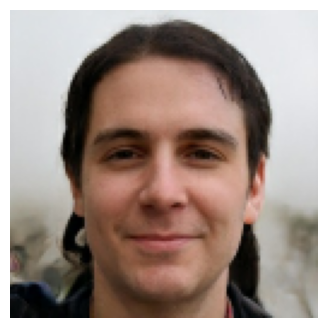

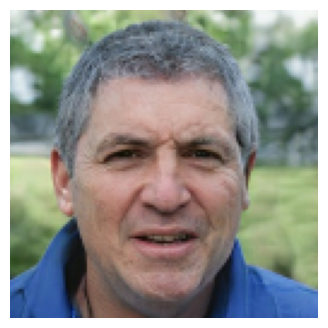

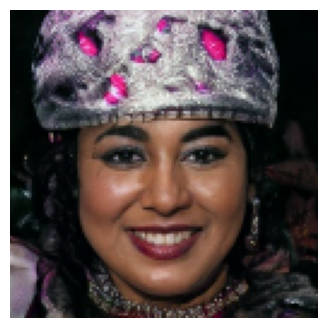

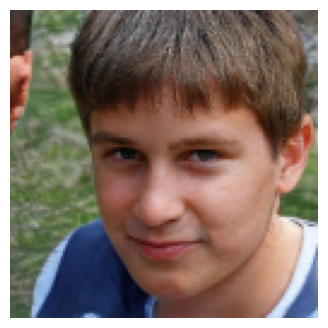

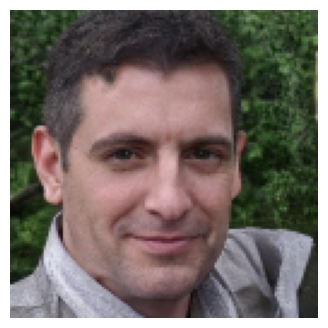

In [6]:
import matplotlib.pyplot as plt

# Take the first batch from the fake_images_dataset
first_batch = next(iter(fake_images_dataset))

# Display some images from the first batch
num_images_to_display = 5
for i in range(num_images_to_display):
    image = first_batch[i].numpy().astype("uint8")  # Convert to NumPy array
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


-------------show some **real images** from **real_images_dataset**----------------

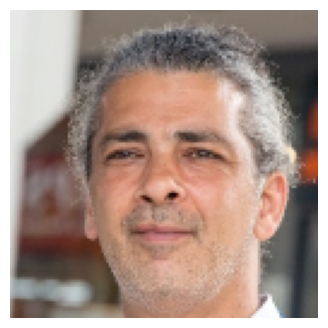

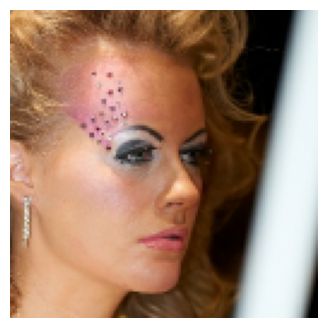

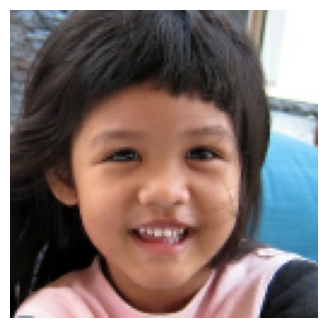

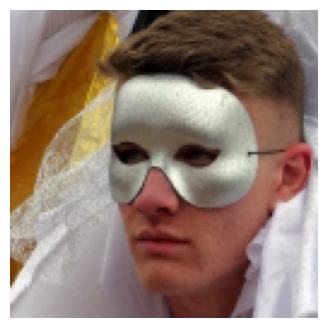

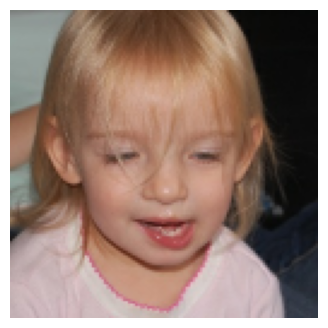

In [7]:
import matplotlib.pyplot as plt

# Take the first batch from the fake_images_dataset
first_batch = next(iter(real_images_dataset))

# Display some images from the first batch
num_images_to_display = 5
for i in range(num_images_to_display):
    image = first_batch[i].numpy().astype("uint8")  # Convert to NumPy array
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

#--------------------- **step 1: completed**--------------

#-------------------------------- **STEP 2 :removal of noise from images**--------------------------

**Kalman Filter**

we have used kalman filter to remove the noise from images

---------------------Define **kalman filter** function to remove the noise from images-----------------

In [8]:
import tensorflow as tf
import cv2
import numpy as np

class KalmanFilter:
    def __init__(self, state_size, measurement_size):
        self.kalman = cv2.KalmanFilter(state_size, measurement_size)
        self.kalman.transitionMatrix = np.eye(state_size, dtype=np.float32)
        self.kalman.measurementMatrix = np.eye(measurement_size, dtype=np.float32)
        self.kalman.processNoiseCov = 1e-5 * np.eye(state_size, dtype=np.float32)
        self.kalman.measurementNoiseCov = 1e-1 * np.eye(measurement_size, dtype=np.float32)
        self.kalman.errorCovPost = np.eye(state_size, dtype=np.float32)

    def filter(self, measurement):
        prediction = self.kalman.predict()
        estimation = self.kalman.correct(measurement)
        return estimation


def preprocess_image(image):
    # Apply Kalman filter
    state_size = 2
    measurement_size = 2
    kalman_filter = KalmanFilter(state_size, measurement_size)

    # Flatten the image array for processing
    flattened_image = image.flatten()

    # Apply Kalman filter to each pixel
    denoised_pixels = [kalman_filter.filter(np.array([[pixel], [0]], dtype=np.float32))[0, 0] for pixel in flattened_image]

    # Reshape the denoised pixels back to the original shape
    denoised_image = np.array(denoised_pixels, dtype=np.uint8).reshape(image.shape)

    return denoised_image


---------------------**Apply Kalman filter on fake images dataset**-------------------

In [9]:
# Apply the denoising process using tf.data.Dataset.map
denoised_fake_dataset = fake_images_dataset.map(lambda img: tf.numpy_function(preprocess_image, [img], tf.uint8))

-------------------print number of batches in denoised fake images

each batch contain 32 images

**number of images= nbr of batches * 32**-------------------

In [11]:
print(len(denoised_fake_dataset))

626


## --------------------------------**show some denoised fake images after applying kalman filter**---------------------------

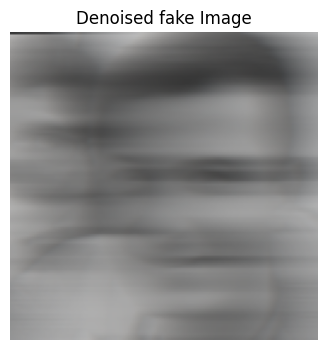

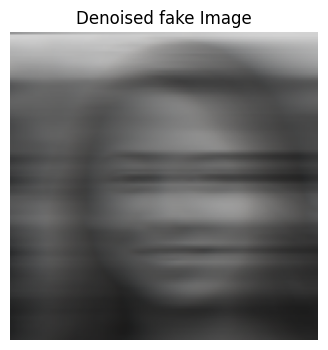

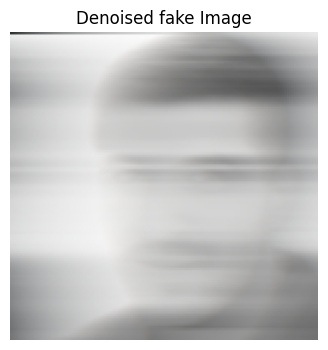

In [19]:
import matplotlib.pyplot as plt
count = 0

for batch in denoised_fake_dataset:
  if count >= 3:
    break
  for img in batch:
    if count >= 3:
      break
    else:
      count += 1
      # Convert the TensorFlow tensor to a NumPy array
      denoised_image = img.numpy().squeeze()

       # Display the image
      plt.figure(figsize=(4, 4))
      plt.title("Denoised fake Image")
      plt.imshow(denoised_image)
      plt.axis("off")
      plt.show()


---------------------------------------**Apply Kalman filter on real images dataset**-----------------------

In [13]:
# Apply the denoising process using tf.data.Dataset.map
denoised_real_dataset = real_images_dataset.map(lambda img: tf.numpy_function(preprocess_image, [img], tf.uint8))

--------------------**print the number of batches in denoised real images dataset after applying kalman filter**------------------------------

In [14]:
print(len(denoised_real_dataset))

634


------------------------------------------**show random denoised real images after applying kalman filter**---------------------------

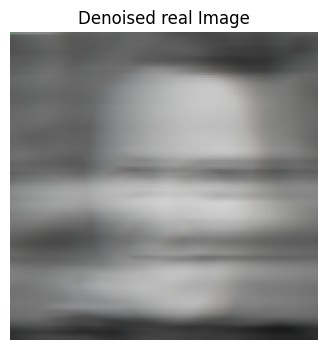

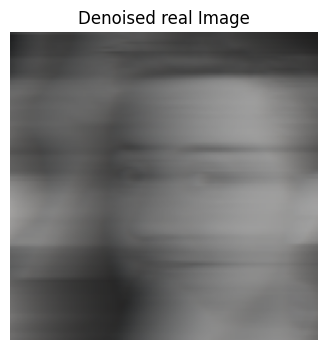

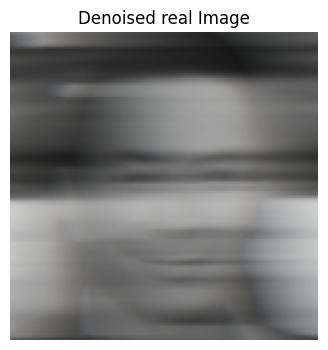

In [18]:
import matplotlib.pyplot as plt
count = 0

for batch in denoised_real_dataset:
  if count >= 3:
    break
  for img in batch:
    if count >= 3:
      break
    else:
      count += 1
      # Convert the TensorFlow tensor to a NumPy array
      denoised_image = img.numpy().squeeze()

       # Display the image
      plt.figure(figsize=(4, 4))
      plt.title("Denoised real Image")
      plt.imshow(denoised_image )
      plt.axis("off")
      plt.show()

# --------------------------------------------**what we have done** --------------------------------------------------

**Remove noise from both real and fake images**


1.   apply kalman filter on real images dataset
2.   apply kalman filter on fake images dataset

we have denoised real images in **denoised_real_dataset**

we have denoised fake images in **denoised_fake_dataset**



-----------------------**lets check again real images and fake images in real and fake images dataset after applying kalman filter**---------------------

In [16]:
print("total number of real images : ",len(real_images_dataset)*32)
print("total number of fake images : ",len(fake_images_dataset)*32)

total number of real images :  20288
total number of fake images :  20032


# -----------------**compare the size of real and fake images dataset using bar char**t-------------------------

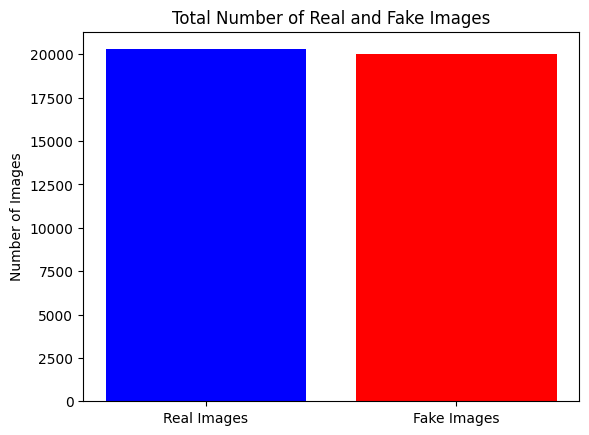

In [17]:
import matplotlib.pyplot as plt

# Assuming batch_size is 32
batch_size = 32

# Calculate the total number of real and fake images
total_real_images = len(real_images_dataset) * batch_size
total_fake_images = len(fake_images_dataset) * batch_size

# Data for the bar graph
categories = ['Real Images', 'Fake Images']
totals = [total_real_images, total_fake_images]

# Create a bar graph
plt.bar(categories, totals, color=['blue', 'red'])
plt.title('Total Number of Real and Fake Images')
plt.ylabel('Number of Images')
plt.show()


#------------------------ **Step : 2   completed**------------------

# --------------------------**Step 3 : merge both datasets and assign labels** ------------------------